# Emotional and Linguistic Framing of Digital Detox

### Notebook 5: Triangulating Topics – LDA vs BERTopic

This analysis uses Latent Dirichlet Allocation (LDA) and BERTopic to identify and compare dominant themes in Reddit posts about digital detox versus a control group. The goal is to examine both emotional and linguistic framing by triangulating insights from two different topic modelling approaches.

### Data Acquisition & Processing

Data consisted of Reddit posts from two subreddits (digital detox and a control group).

Text data was preprocessed using:
- Tokenisation ensuring consistency with linguistic principles.
- Conversion of preprocessed tokens into strings for LDA input.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.stats import chi2_contingency
import ast  # to parse token strings back to lists if needed

In [2]:
# Load data
detox_df = pd.read_csv("/home/jovyan/XXX/Back up/XXX/balanced_detox_posts.csv")
control_df = pd.read_csv("/home/jovyan/XXX/Back up/XXX/balanced_control_posts.csv")

In [3]:
# function to convert string lists back to lists
def fix_tokens(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    elif isinstance(x, list):
        return x
    else:
        return []

# apply to both datasets
detox_df['body_tokens'] = detox_df['body_tokens'].apply(fix_tokens)
control_df['body_tokens'] = control_df['body_tokens'].apply(fix_tokens)

# join tokens into strings for LDA
detox_texts = detox_df['body_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()
control_texts = control_df['body_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()

### Topic Modeling: LDA

- LDA models were trained separately on each group.
- Top 5 topics were extracted per group.
- Each post was assigned a dominant topic (the one with the highest probability).

In [4]:
# LDA Topic Modelling Function
# https://www.datacamp.com/tutorial/lda2vec-topic-model
def run_lda(texts, n_topics=5, max_features=1000):
    vectorizer = CountVectorizer(stop_words='english', max_features=max_features)
    X = vectorizer.fit_transform(texts)

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50, random_state=42)
    lda.fit(X)

    topics = []
    for idx, topic in enumerate(lda.components_):
        top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:][::-1]]
        topics.append(top_words)
        print(f"Topic {idx}: {top_words}")
    return lda, vectorizer, topics, X

In [5]:
# run LDA on detox group
# detox topics
detox_lda_model, detox_vectorizer, detox_topics, detox_X = run_lda(detox_texts, n_topics=5)

Topic 0: ['time', 'phone', 'like', 'hours', 'day', 'read', 'internet', 'digital', 'reading', 'work']
Topic 1: ['phone', 'social', 'media', 'time', 'like', 'use', 'people', 'reddit', 'apps', 'want']
Topic 2: ['dopamine', 'brain', 'social', 'media', 'addiction', 'internet', 'work', 'life', 'digital', 'activities']
Topic 3: ['day', 'detox', 'time', 'dopamine', 'days', 'like', 'hours', 'week', 'want', 'youtube']
Topic 4: ['like', 'life', 'feel', 'time', 'people', 'things', 'really', 'mind', 'thoughts', 'know']


In [6]:
# run LDA on control group
# control topics
control_lda_model, control_vectorizer, control_topics, control_X = run_lda(control_texts, n_topics=5)

Topic 0: ['told', 'said', 'like', 'time', 'got', 'asked', 'know', 'day', 'went', 'going']
Topic 1: ['mom', 'job', 'years', 'family', 'life', 'parents', 'time', 'want', 'work', 'dad']
Topic 2: ['like', 'friends', 'feel', 'really', 'people', 'know', 'want', 'friend', 'talk', 'things']
Topic 3: ['like', 'people', 'think', 'know', 'life', 'really', 'question', 'want', 'time', 'say']
Topic 4: ['like', 'feel', 'know', 'love', 'life', 'want', 'felt', 'time', 'way', 'think']


In [7]:
# assign dominant LDA topic to each post
detox_topic_dist = detox_lda_model.transform(detox_X)
detox_df['dominant_topic'] = detox_topic_dist.argmax(axis=1)

control_topic_dist = control_lda_model.transform(control_X)
control_df['dominant_topic'] = control_topic_dist.argmax(axis=1)

### Comparison Between Groups

- A chi-square test showed whether topic distributions differ significantly between groups.
- Result: [Insert whether significant or not] — this reveals structural differences in thematic focus.
- Jaccard similarity was used to compare lexical overlap between topics across groups.
- Result visualised with a heatmap for interpretability.

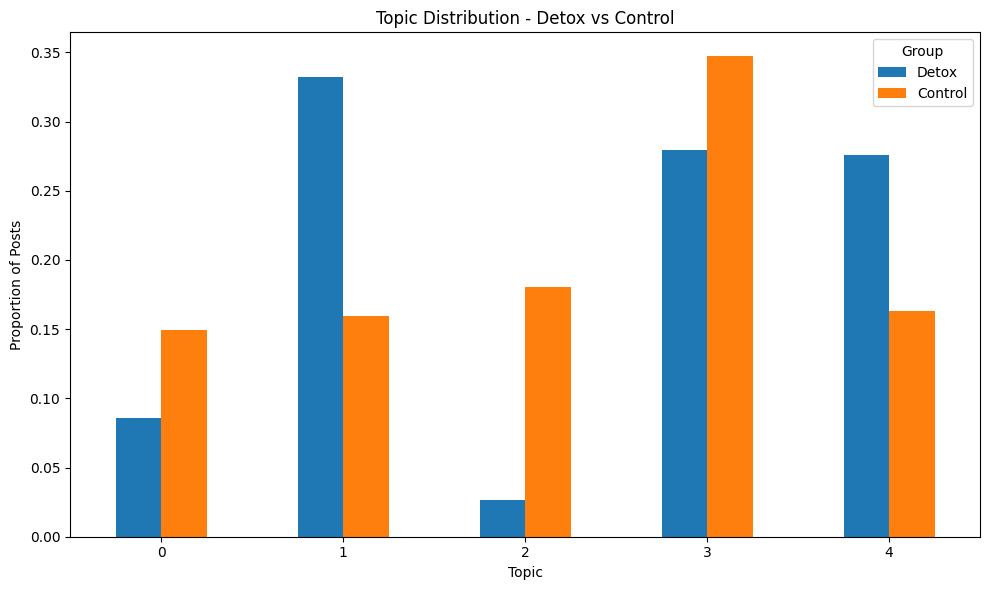

In [8]:
# count number of posts per topic
detox_counts = detox_df['dominant_topic'].value_counts().sort_index()
control_counts = control_df['dominant_topic'].value_counts().sort_index()

# create df for comparison
topic_counts_df = pd.DataFrame({'Detox': detox_counts, 'Control': control_counts}).fillna(0).astype(int)

# normalise proportions
topic_counts_norm = topic_counts_df.div(topic_counts_df.sum(axis=0), axis=1)

# plot
topic_counts_norm.plot.bar(figsize=(10, 6), title="Topic Distribution - Detox vs Control")
plt.ylabel("Proportion of Posts")
plt.xlabel("Topic")
plt.xticks(rotation=0)
plt.legend(title="Group")
plt.tight_layout()
plt.show()

The normalised topic distribution reveals clear differences between the Detox and Control groups

- Topic 1 is much more prominent in Detox
- Topic 2 is dominant in Control
- Topic 3 appears fairly balanced across both groups,
- Topics 0 and 4 show mixed but less pronounced differences.

These patterns suggest the detox intervention shifted discussion focus toward certain themes and away from others

In [9]:
# chi-square test
# https://www.datacamp.com/tutorial/chi-square-test-r
chi2, p, _, _ = chi2_contingency(topic_counts_df.T)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")
print("significant difference" if p < 0.05 else "no significant difference.")

Chi² = 799.27, p = 0.0000
significant difference


The chi-square test results strongly confirm what the visual patterns suggested - there is a statistically significant difference in topic distributions between the Detox and Control groups.

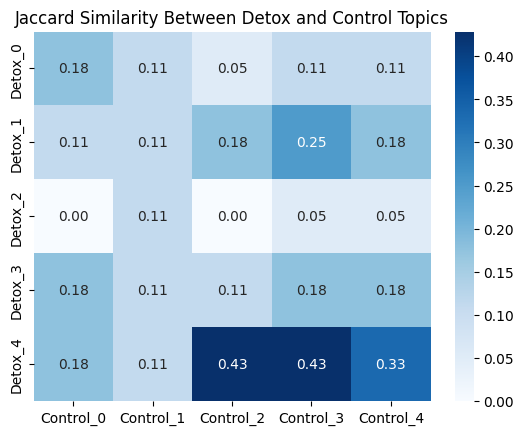

In [10]:
# function to compute Jaccard similarity
# code adapted from NLP revision 
def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

# compute pairwise similarities
jaccard_matrix = np.zeros((len(detox_topics), len(control_topics)))
for i, dt_topic in enumerate(detox_topics):
    for j, ct_topic in enumerate(control_topics):
        jaccard_matrix[i, j] = jaccard_similarity(set(dt_topic), set(ct_topic))

# create and plot heatmap
jaccard_df = pd.DataFrame(jaccard_matrix,
                          index=[f"Detox_{i}" for i in range(len(detox_topics))],
                          columns=[f"Control_{j}" for j in range(len(control_topics))])

sns.heatmap(jaccard_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Jaccard Similarity Between Detox and Control Topics")
plt.show()

The Jaccard similarity heatmap shows that topics between Detox and Control groups are mostly distinct, reflecting the detox intervention’s strong impact on content. Detox_4 overlaps notably with several Control topics, but most similarities are low (0.00–0.25). Detox_2 is especially unique to Detox, with almost no overlap. Moderate similarities exist but don’t imply equivalence. Overall, the detox condition created new, distinct themes rather than just suppressing existing ones, indicating a transformative change in discussion content.

### Emotional Tone by Topic

- Used TextBlob to calculate polarity (positive/negative tone) and subjectivity per post.
- Mapped emotional tone back to each LDA topic, enabling emotional profiling by theme.

In [11]:
# function to plots boxplot per emotion column per topic,
def plot_emotion_by_topic(df, textblob_cols=['polarity', 'subjectivity'], vad_cols=[], group_name=""):
    emotion_cols = textblob_cols + vad_cols
    for col in emotion_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='dominant_topic', y=col, data=df)
        plt.title(f'{group_name} - {col} by Dominant Topic')
        plt.xlabel('Dominant Topic')
        plt.ylabel(col.capitalize())
        plt.tight_layout()
        plt.show()

  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


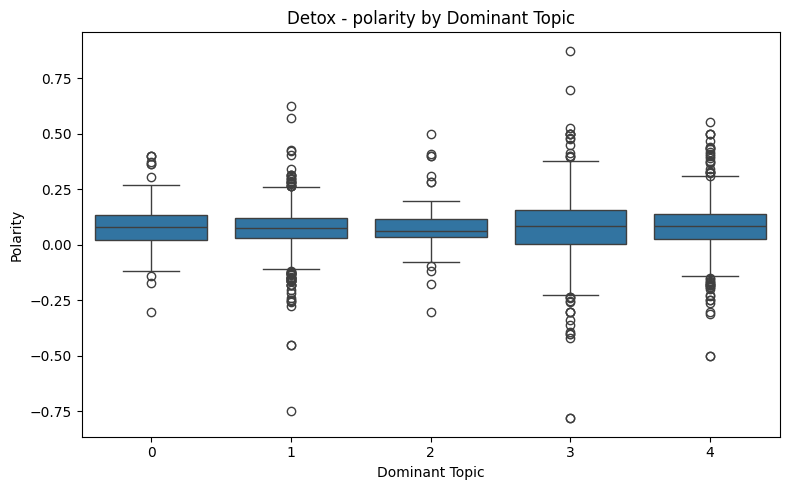

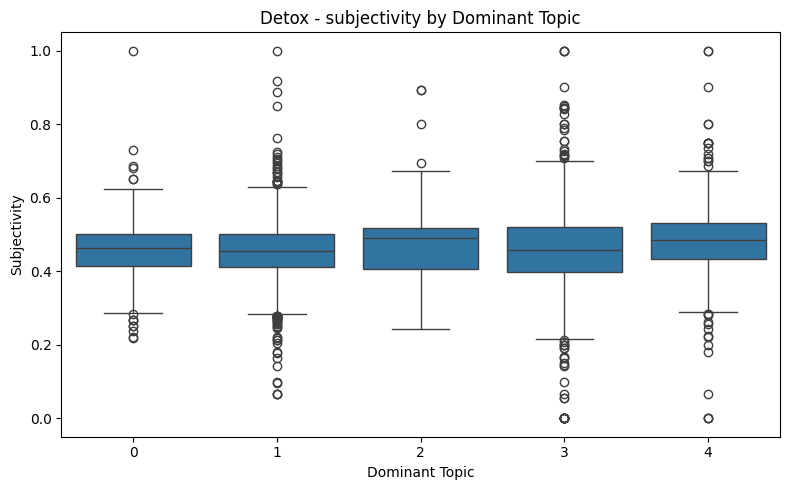

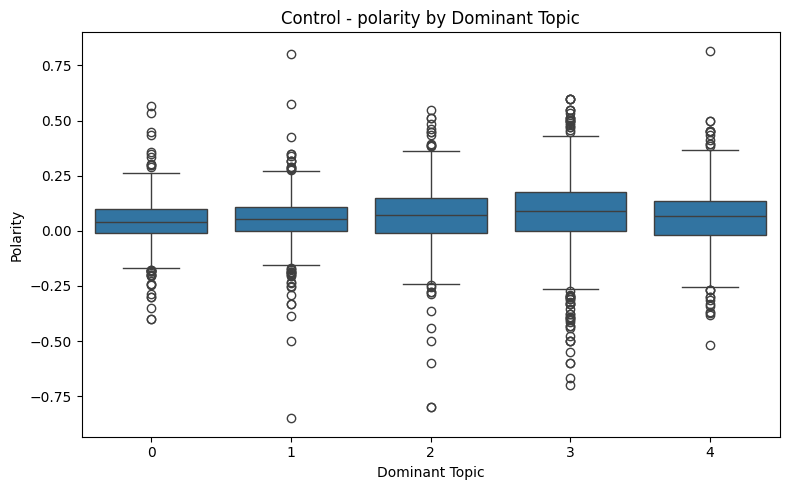

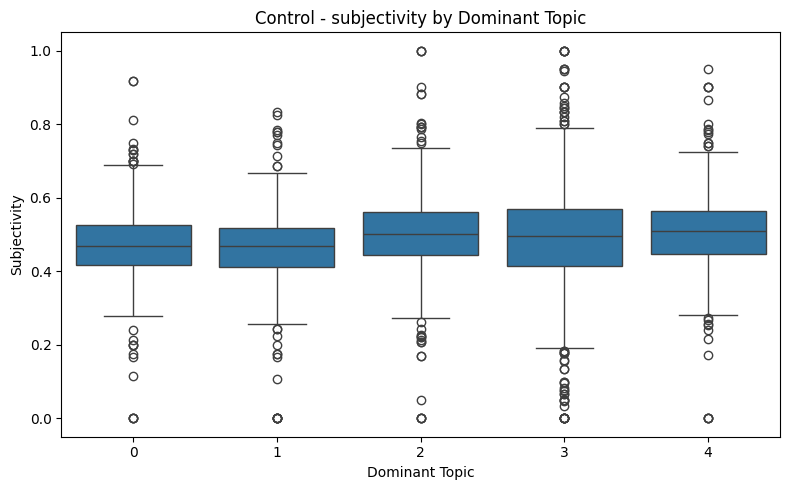

In [12]:
!pip install textblob
from textblob import TextBlob

# apply polarity and subjectivity using textblob 
for df, name in [(detox_df, "Detox"), (control_df, "Control")]:
    # calculate polarity 
    df['polarity'] = df.get('polarity', df['body'].apply(lambda x: TextBlob(x).sentiment.polarity))
    # calculate subjectivity
    df['subjectivity'] = df.get('subjectivity', df['body'].apply(lambda x: TextBlob(x).sentiment.subjectivity))
    # plot distribution
    plot_emotion_by_topic(df, textblob_cols=['polarity', 'subjectivity'], group_name=name)

The Detox group shows more emotionally balanced communication with median polarity around 0.1–0.15, while the Control group has more emotional variability, especially in Topics 2 and 3. Topic 3 is generally more positive in both groups. Detox participants also communicate more subjectively (median 0.45–0.55) than Control, who lean toward factual content. Topics 2, 3, and 4 naturally invite more subjective input. Overall, Detox promotes calmer yet more personally engaging discussions, suggesting healthier digital communication.

### Triangulation with BERTopic

- Posts were also modelled using BERTopic (transformer-based method with clustering)
- Cross-tabulated LDA and BERT topics to
    - See overlap and divergence
    - Detect which LDA topics were tightly or loosely aligned with specific BERT clusters
- Visualised by heatmaps for each group

In [13]:
# load preprocessed BERT topic labels
detox_df_bert = pd.read_csv("/home/jovyan/XXX/Back up/XXX/detox_with_topics.csv")
control_df_bert = pd.read_csv("/home/jovyan/XXX/Back up/XXX/control_with_topics.csv")

# apply token repair and prepare texts
detox_df_bert['body_tokens'] = detox_df_bert['body_tokens'].apply(fix_tokens)
control_df_bert['body_tokens'] = control_df_bert['body_tokens'].apply(fix_tokens)

# convert tokens to strings for LDA transformation
detox_texts_bert = detox_df_bert['body_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()
control_texts_bert = control_df_bert['body_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()

# https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html#parameters
# trained vectorisers and LDA models
X_bert_detox = detox_vectorizer.transform(detox_texts_bert)
lda_topic_dist_detox = detox_lda_model.transform(X_bert_detox)
detox_df_bert['dominant_topic'] = lda_topic_dist_detox.argmax(axis=1)

X_bert_control = control_vectorizer.transform(control_texts_bert)
lda_topic_dist_control = control_lda_model.transform(X_bert_control)
control_df_bert['dominant_topic'] = lda_topic_dist_control.argmax(axis=1)

In [14]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#reshaping-crosstabulations
# https://github.com/jhewitt11/Topic-Modeling-BERTopic-and-LDA
# crosstabs to compare model agreement
detox_crosstab = pd.crosstab(detox_df_bert['dominant_topic'], detox_df_bert['topic'], normalize='index')
control_crosstab = pd.crosstab(control_df_bert['dominant_topic'], control_df_bert['topic'], normalize='index')

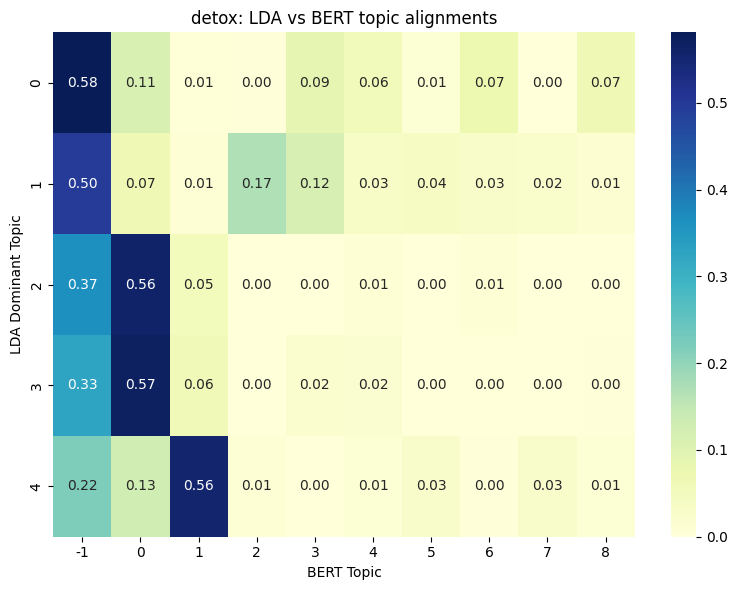

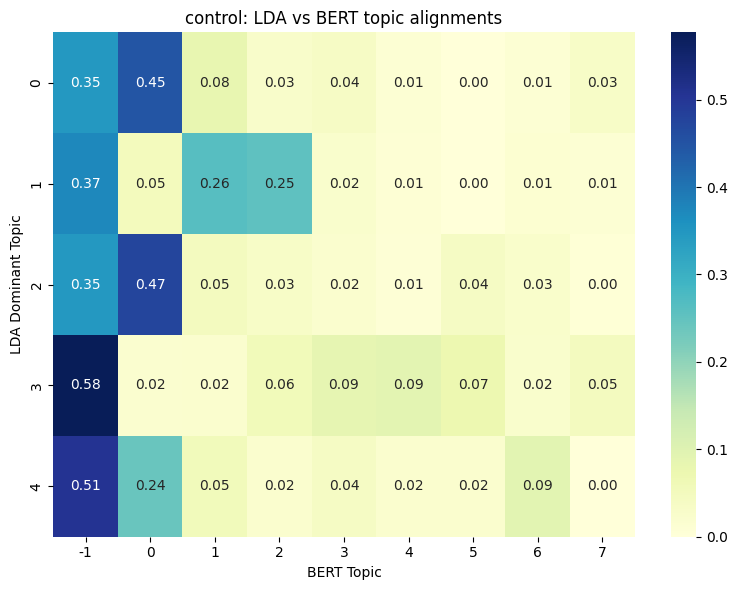

In [15]:
# https://pytutorial.com/python-seaborn-heatmap-tutorial-data-visualization/
# function to plot both heatmaps
def plot_heatmap(data, title):
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("BERT Topic")
    plt.ylabel("LDA Dominant Topic")
    plt.tight_layout()
    plt.show()

for data, title in [(detox_crosstab, "detox: LDA vs BERT topic alignments"),
                    (control_crosstab, "control: LDA vs BERT topic alignments")]:
    plt.figure(figsize=(8,6))
    plot_heatmap(data, title)

### Critical Reflection

Topic alignment heatmaps reveal clear differences between Detox and Control groups. In Detox, LDA topics align strongly with single BERT topics, showing a more fragmented but focused structure with minimal overlap. In contrast, the Control group shows distributed alignments, indicating more blended, interconnected discussions. BERT Topic -1 dominates in Detox, suggesting a key theme unique to that condition. Overall, the detox intervention led to clearer, more distinct topical discourse, while control discussions were more complex and diffuse.